In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 1 Classify each transaction in the data by its “source of business” based on the treated patient’s prior product use. 

First, we load the dataset and check if any missing data contained.

In [2]:
transaction_data = pd.read_csv('Analysis_and_coding_task_data.csv', header=0, parse_dates=['transaction_date'])
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91244 entries, 0 to 91243
Data columns (total 4 columns):
patient_id          91244 non-null int64
transaction_date    91244 non-null datetime64[ns]
transaction_id      91244 non-null int64
product_name        91244 non-null object
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 2.8+ MB


By using `.info()` method, we see that there is no missing data. Then we sort data sequentially by `patient_id`, `transaction_date` and `transaction_id`

In [3]:
transaction_data = transaction_data.sort_values(['patient_id', 'transaction_date', 'transaction_id']).reset_index(drop=True)

transaction_patient = transaction_data.groupby('patient_id', as_index=False)

Now we define a function `transaction_classify` to add a new column `source of buisness`, and apply it to each group in `transaction_patient`

In [4]:
### for each patient, compare the product in each transaction and the previous one

def transaction_classify(dt):
    dt_0 = dt.copy(deep=True)                                          #keep the original group not shifted
    dt_0['product_name'] = dt_0['product_name'].shift(1)
    transaction = []
    for i in dt.index:
        if pd.isnull(dt_0.loc[i, 'product_name']):
            transaction.append('New Start')
        elif dt_0.loc[i, 'product_name'] == dt.loc[i, 'product_name']:
            transaction.append('Continuation')
        else:
            transaction.append('Switch')
    del dt_0                                                          #save space
    dt['source of buisness'] = transaction
    return dt


transaction_data_updated = transaction_patient.apply(transaction_classify)

### 2. Visualize the “patient journey” for individual patients, plotting the transaction data and product use over the range of the data for a selected small subset of patients.

This task is completed using `R`

In [9]:
transaction_data_updated.to_csv('transaction data updated.csv', index=False)

### 3. Analyze patient gains and losses due to product switching over time. 

Here we group the data by `patient_id`. For a patient, each product switch contribute 1 gain for the post-switch product and 1 loss for the before-switch product in the corresponding year. 

In [102]:
#transaction_data_updated = pd.read_csv('transaction data updated.csv', header=0, parse_dates=['transaction_date'])
transaction_patient_updated = transaction_data_updated.groupby('patient_id')
year_span = transaction_data_updated['transaction_date'].dt.year.unique()   #get year range of the dataset
product = transaction_data_updated['product_name'].unique()                 #get product categories
product_gain = pd.DataFrame(np.zeros((len(year_span), len(product))), index=year_span, columns=product, dtype=int)
product_loss = pd.DataFrame(np.zeros((len(year_span), len(product))), index=year_span, columns=product, dtype=int)
for _, patient in transaction_patient_updated:
    year_switch = patient[patient['source of buisness'] == 'Switch']['transaction_date'].dt.year.tolist()
    #year_new_start = patient[patient['source of buisness'] == 'New Start']['transaction_date'].dt.year.tolist()
    product_after_switch = patient[patient['source of buisness'] == 'Switch']['product_name'].tolist()
    product_before_switch_index = patient[patient['source of buisness'] == 'Switch'].index.values - 1
    product_before_switch = patient.loc[product_before_switch_index, 'product_name'].tolist()
    #product_new_start = patient[patient['source of buisness'] == 'New Start']['product_name'].tolist()
    product_gain.loc[year_switch, product_after_switch] += 1
    #product_gain.loc[year_new_start, product_new_start] += 1
    product_loss.loc[year_switch, product_before_switch] += 1

Then we can visualize the annual trend of patients gain and loss for each product

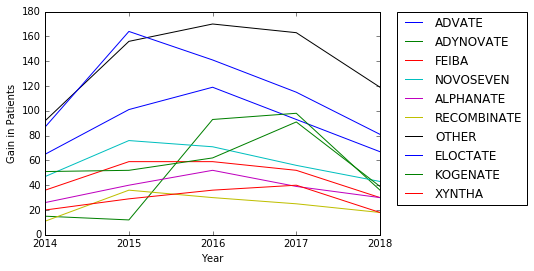

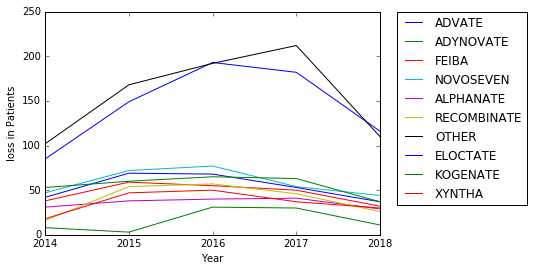

In [104]:
product_gain.plot.line()
plt.xticks(product_gain.index.tolist(), product_gain.index.tolist())
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Year')
plt.ylabel('Gain in Patients')
plt.show()
product_loss.plot.line()
plt.xticks(product_gain.index.tolist(), product_gain.index.tolist())
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Year')
plt.ylabel('loss in Patients')
plt.show()

The net patient change can be calculated by `product_gain - product_loss`, from which we see that `ADVATE` and `RECOMBINATE` lose patient due to switching product every year, whereas `ADYNOVATE` and `ELOCTATE` gain. The net change of aLL other products (including `other`) vary back and forth.

In [106]:
annual_net_change = product_gain - product_loss
print(annual_net_change)

      ADVATE  ADYNOVATE  FEIBA  NOVOSEVEN  ALPHANATE  RECOMBINATE  OTHER  \
2014     -20          7     -2          0         -5           -5    -10   
2015     -48          9      0          4          2          -18    -12   
2016     -74         62      4         -6         12          -27    -22   
2017     -89         68      2          2         -2          -21    -49   
2018     -49         25     -2         -1          1           -8      9   

      ELOCTATE  KOGENATE  XYNTHA  
2014        45        -2       2  
2015        95        -8     -18  
2016        73        -3     -14  
2017        62        28       3  
2018        44         2     -12  


### 4. Identify the most common pairs of products driving net patient movement from product switching.

We first calculate the product A to product B for all (A,B) products combinations for each patient, and then sum them up.

In [123]:
from itertools import permutations
from collections import Counter, defaultdict

product_pair = list(permutations(product, 2))    #get all pairs of (Product A, Product B)



In [164]:
product_pair_key = list(map(lambda x: ' to '.join(x), product_pair))  ##get string `Product A to Product B`
product_pair_dict = {v: 0 for v in product_pair_key}                  ##initialize pairwise switch

for _, patient in transaction_patient_updated:
    if any(patient['source of buisness'] == 'Switch'):
        product_after_switch = patient[patient['source of buisness'] == 'Switch']['product_name'].values[0]
        product_before_switch_index = patient[patient['source of buisness'] == 'Switch'].index.values - 1
        product_before_switch = patient.loc[product_before_switch_index, 'product_name'].values[0]
        pair = ' to '.join([product_before_switch, product_after_switch])
        product_pair_dict[pair] += 1
    


Print 10 product switching with the largest patient gains. The one with the very largest gains is switching from `ADVATE` to `ELOCTATE`, by 170 patients in total from 2014 to 2018.

In [167]:
print(Counter(product_pair_dict).most_common(10))

[('ADVATE to ELOCTATE', 170), ('OTHER to KOGENATE', 109), ('ADVATE to OTHER', 107), ('ADVATE to ADYNOVATE', 102), ('OTHER to ELOCTATE', 101), ('KOGENATE to OTHER', 69), ('OTHER to ADVATE', 46), ('KOGENATE to ELOCTATE', 39), ('NOVOSEVEN to FEIBA', 38), ('RECOMBINATE to ELOCTATE', 36)]


### 5. Contemplate a new approach to identifying switching allow for patients to use multiple products simultaneously. 

Misclassifying combination therapies as switches are mainly caused by only concerning the consistency in `product_name` rather than considering other issues as well. For instance, if consecutive switches happen on the same `transaction_date`, and the `product_name` varies among several fixed products (i.e., $Product\ A \rightarrow Product\ B \rightarrow Product\ A \rightarrow Product\ B...$), then this pattern verly likely indicates the patient is using combination therapies. A possible rule to avoid such misclassification is that if multiple switches among a group of products in one day repeatedly happen in the following days, the journey should be treated as combination therapies; additionally, if one product in combination therapies is identical with the closest previously used product (the time interval length between the beginning of combination therapies and the closest previous journey segment needs to be considered as well, say, less than 2 weeks), the part of the combination therapies should be considered as the extension of the previous journey. For example, for  $Product\ A \rightarrow Product\ A \rightarrow Product\ A \rightarrow Product\ A \rightarrow \mathbf{Product\ A} \rightarrow Product\ B \rightarrow \mathbf{Product\ A} \rightarrow Product\ B...$, $Product\ A \rightarrow Product\ A \rightarrow Product\ A \rightarrow Product\ A \rightarrow \mathbf{Product\ A} \rightarrow \mathbf{Product\ A} ...$ is a consecutive journey. A practical way is find combination therapies is to calculate the daily number of product switch for each patient, and if within a period that 

group patients' transaction record by `transaction_date` and check the number of `source of buisness = Switch` within each daily group

Please see the modified journey visualizaiton in R part.   

In [163]:
print(any(patient['source of buisness'] == 'Switch'))
print((patient[patient['source of buisness'] == 'Switch'].empty))
print(product_gain)
product_gain.loc[[],[]] += 3
print(product_gain)

False
True
      ADVATE  ADYNOVATE  FEIBA  NOVOSEVEN  ALPHANATE  RECOMBINATE  OTHER  \
2014      65         15     36         47         26           11     92   
2015     101         12     59         76         40           36    156   
2016     119         93     59         71         52           30    170   
2017      93         98     52         56         39           25    163   
2018      67         36     30         43         30           18    119   

      ELOCTATE  KOGENATE  XYNTHA  
2014        87        51      20  
2015       164        52      29  
2016       141        62      36  
2017       115        91      40  
2018        81        39      18  
      ADVATE  ADYNOVATE  FEIBA  NOVOSEVEN  ALPHANATE  RECOMBINATE  OTHER  \
2014      65         15     36         47         26           11     92   
2015     101         12     59         76         40           36    156   
2016     119         93     59         71         52           30    170   
2017      93      